# Reptrix Tutorial 

In this tutorial, we show how to use reptrix to assess representations of a model pretrained using self-supervised learning. 

Here we use the [STL-10](https://cs.stanford.edu/~acoates/stl10/) dataset, which contains 10 classes of images. 

We will use the [Barlow Twins](https://arxiv.org/abs/2103.03230), and [DINO](https://arxiv.org/abs/2104.14294) models as examples.

To assess the quality of the learned representations, we will use various metrics, including:

- **Alpha**: This metric computes the eigenvalues of the covariance matrix of the representations and fits a power-law distribution to them. The exponent of the power-law distribution is called the alpha exponent, which measures the heavy-tailedness of the distribution. A lower alpha exponent indicates that the representations are more discriminative.

- **RankMe**: This metric computes the rank of the covariance matrix of the representations. A higher rank indicates representations of higher capacity.


We will compute these metrics using the Reptrix library, which provides a convenient interface for representation analysis. Let's dive into the code and explore the evaluation process in detail.



## Import everything we need

In [1]:
import torch
import torchvision
from tqdm import tqdm
from reptrix import alpha, rankme
import reptrix

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Function to get the features of from the pretrained encoder model using a dataset. 

In [10]:
def get_features(encoder_function, dataloader):
    # Loop over the dataset and collect the representations
    all_features = []

    # Loop over the dataset and collect the representations
    for i, data in enumerate(tqdm(dataloader, 0)):
        inputs, _ = data
        with torch.no_grad():
            features = encoder_function(inputs.to(device))
            all_features.append(features)
            
    # Concatenate all the features
    all_features = torch.cat(all_features, dim=0)
    return all_features

## Get the STL-10 dataset and the pretrained models

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4467, 0.4398, 0.4066), (0.2242, 0.2215, 0.2239))
])

# Get the STL10 test dataset to measure the quality of the representations learned by the model
testset = torchvision.datasets.STL10(root='./data', split='test', download=False, transform=torchvision.transforms.ToTensor())

# Define a dataloader to load the test dataset
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=4)

### 1. ResNet50 encoder trained with Barlow Twins

In this section, we will evaluate the representations learned by an encoder trained with the Barlow Twins method.

In [4]:
# Define a resnet encoder using pytorch where you can load the weights from a pre-trained model
# We will use encoder that is trained using Barlow Twins
encoder = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
# Remove the final fully connected layer so that the model outputs the 2048 feature vector
encoder = torch.nn.Sequential(*(list(encoder.children())[:-1]))

Using cache found in /home/mila/a/arnab.mondal/.cache/torch/hub/facebookresearch_barlowtwins_main
/home/mila/a/arnab.mondal/.conda/envs/equiadapt/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mila/a/arnab.mondal/.conda/envs/equiadapt/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
# Move the model to the device
encoder = encoder.to(device)

# Set the model to evaluation mode
encoder.eval()
    
all_representations = get_features(encoder, testloader)

100%|██████████| 32/32 [00:02<00:00, 12.10it/s]


In [16]:
metric_alpha = alpha.get_alpha(all_representations)
metric_rankme = rankme.get_rankme(all_representations)
print(f'Values of different metrics: Alpha: {metric_alpha[0]}, Rankme: {metric_rankme}')

Values of different metrics: Alpha: 0.9257935601732855, Rankme: 311.6012878417969


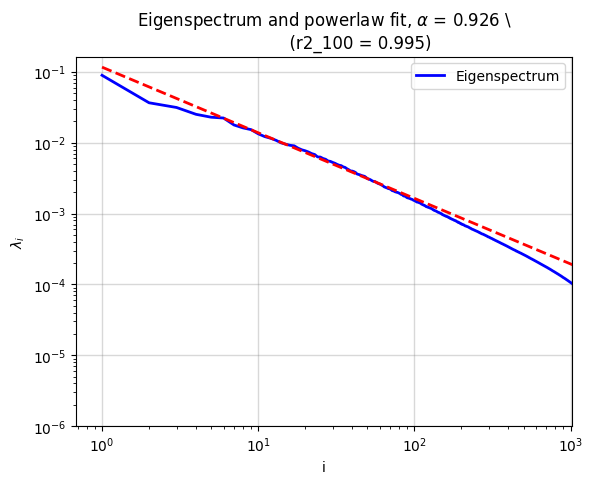

In [17]:
# Plot the eigenspectrum and the powerlaw fit
eigenspectrum = reptrix.utils.get_eigenspectrum(all_representations.cpu())

# reptrix.utils.plot_eigenspectrum(eigenspectrum)
reptrix.alpha.plot_powerlaw(eigenspectrum, metric_alpha)

### 2. Vit Encoder trained with DINO

In [18]:
# Define a vit encoder using pytorch where you can load the weights from a pre-trained model
# We will use encoder that is trained using Dino
encoder = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')


Using cache found in /home/mila/a/arnab.mondal/.cache/torch/hub/facebookresearch_dino_main


In [19]:
# Move the model to the device
encoder = encoder.to(device)

# Set the model to evaluation mode
encoder.eval()
    
all_representations = get_features(encoder.forward, testloader)

print('Shape of the representations:', all_representations.shape) 

100%|██████████| 32/32 [00:02<00:00, 15.31it/s]

Shape of the representations: torch.Size([8000, 384])


In [20]:
metric_alpha = alpha.get_alpha(all_representations)
metric_rankme = rankme.get_rankme(all_representations)
print(f'Values of different metrics: Alpha: {metric_alpha[0]}, Rankme: {metric_rankme}')

Values of different metrics: Alpha: 0.8250617965166271, Rankme: 152.5411376953125


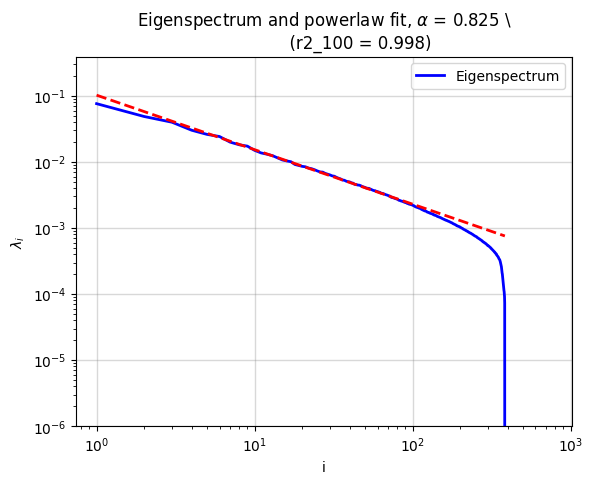

In [21]:
# Plot the eigenspectrum and the powerlaw fit
eigenspectrum = reptrix.utils.get_eigenspectrum(all_representations.cpu())

# reptrix.utils.plot_eigenspectrum(eigenspectrum)
reptrix.alpha.plot_powerlaw(eigenspectrum, metric_alpha)